# 01. Análisis de los datos e ingeniería de features

## Importar librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rake_nltk import Rake
from sklearn.preprocessing import MinMaxScaler

## Leer dataset

In [2]:
df_movies = pd.read_csv('../datasets/imdb_top_1000.csv')
df_movies_original = df_movies.copy()

In [3]:
df_movies.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


### Tipos de dato

In [4]:
df_movies.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [5]:
df_movies.dtypes.value_counts()

object     13
float64     2
int64       1
dtype: int64

Tenemos 13 variables de texto que incluyen variables categóricas y algunas que requieren de preprocesamiento.
Tenemos 3 variables numéricas que corresponden a cantidad de votos, ratings y scores. 

### Número de features y observaciones

In [6]:
df_movies.shape

(1000, 16)

Tenemos 16 variables diferentes y 1000 observaciones (ejemplos) en el dataset.

### Valores nulos

In [7]:
df_movies.isna().any()

Poster_Link      False
Series_Title     False
Released_Year    False
Certificate       True
Runtime          False
Genre            False
IMDB_Rating      False
Overview         False
Meta_score        True
Director         False
Star1            False
Star2            False
Star3            False
Star4            False
No_of_Votes      False
Gross             True
dtype: bool

Tenemos valores nulos explícitos en las variables 'Certificate', 'Meta_score' y 'Gross'

In [8]:
df_movies.isna().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

Al final se omiten las columnas Gross y Meta_Score, pues se espera que aporten poco a la decisión de recomendar una película. Se llenan los valores nulos con ceros.

In [9]:
df_movies.fillna(0, inplace = True)

## Ingeniería de features

### Gross

Gross debería ser una variable numérica pero su tipo es object, por lo que debemos analizarla.

In [10]:
df_movies.Gross.head()

0     28,341,469
1    134,966,411
2    534,858,444
3     57,300,000
4      4,360,000
Name: Gross, dtype: object

In [11]:
df_movies.Gross = df_movies.Gross.apply(lambda x: float(str(x).replace(',','')))

In [12]:
df_movies.Gross.head()

0     28341469.0
1    134966411.0
2    534858444.0
3     57300000.0
4      4360000.0
Name: Gross, dtype: float64

### Runtime

La variable "runtime" de la película debería ser numérica. Se debe corregir el formato

In [13]:
df_movies.Runtime

0      142 min
1      175 min
2      152 min
3      202 min
4       96 min
        ...   
995    115 min
996    201 min
997    118 min
998     97 min
999     86 min
Name: Runtime, Length: 1000, dtype: object

In [14]:
df_movies['Runtime'] = df_movies['Runtime'].apply(lambda x: float(x[0:-4]))

Se bucketiza (binning) para agrupar las películas según su duración y que las películas con muchos minutos no se recomienden entre sí solo por la duración. Queremos que sea un componente más para la decisión de la recomendación.

In [15]:
df_movies['Bucketized_Runtime'], cut_bin = pd.qcut(df_movies['Runtime'], q = 5, labels = [1, 2, 3, 4, 5], retbins = True)

In [16]:
df_movies['Bucketized_Runtime']

0      4
1      5
2      5
3      5
4      1
      ..
995    3
996    5
997    3
998    1
999    1
Name: Bucketized_Runtime, Length: 1000, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

Se deben escalar los datos del runtime bucketizado para que de esta forma el modelo no tenga sesgo en esta variable.

In [17]:
scaler = MinMaxScaler()
scaler.fit(df_movies[['Bucketized_Runtime']])
df_movies[['Bucketized_Runtime']] = scaler.transform(df_movies[['Bucketized_Runtime']])

### Released Year

El año de lanzamiento puede ser agrupado en décadas. 

Hay 1 valor no numérico en la columna. Manualmente puede ser corregido. Apollo 13 es una película de 1995.

In [18]:
df_movies.loc[df_movies['Released_Year'] == 'PG', 'Released_Year'] = 1995
df_movies['Released_Year'] = df_movies['Released_Year'].astype(int)

In [19]:
df_movies['Decade'] = df_movies['Released_Year'].apply(lambda x: 90+int((x % 100)/10) if int((x % 100)/10) == 2 and int(x/100) == 19 else int((x % 100)/10)).astype(str)

Cada década tiene su número indicando la decena. La decada de 1920 se representa con "92".

In [20]:
df_movies['Decade'].value_counts(normalize=True)

1     0.242
0     0.237
9     0.151
8     0.089
7     0.076
6     0.073
5     0.056
4     0.035
3     0.024
92    0.011
2     0.006
Name: Decade, dtype: float64

### Genre

Para la variable género hay algunas que tienen varios géneros en la misma columna.

In [21]:
df_movies.Genre

0                         Drama
1                  Crime, Drama
2          Action, Crime, Drama
3                  Crime, Drama
4                  Crime, Drama
                 ...           
995      Comedy, Drama, Romance
996              Drama, Western
997         Drama, Romance, War
998                  Drama, War
999    Crime, Mystery, Thriller
Name: Genre, Length: 1000, dtype: object

In [22]:
# Esta lista contiene los géneros de todas las peliculas con las repeticiones correspondientes.
generos_totales = [item for row in df_movies['Genre'].apply(lambda x: str(x).split(', ')) for item in row]

Codificamos la variable categórica del género de forma numérica. Se añade una columna por cada género y se agrega un 1 en la matriz si la película (fila) corresponde al género (columna).

In [23]:
# Lista con los generos sin repeticion
generos = list(set(generos_totales))

df_genres = pd.DataFrame(np.zeros((1000, len(generos))))
df_genres.columns = [f'Genre-{genre}' for genre in generos]

df_movies = pd.concat([df_movies, df_genres], axis = 1)

In [24]:
for index, row in df_movies.iterrows():
    for genre in row['Genre'].split(', '):
        df_movies.loc[index, 'Genre-'+genre] = 1

### Star

Las columnas "Star" representan actores, pero están separados en 4 columnas.

In [25]:
# Esta lista agrupa los actores de todas las películas con sus respectivas repeticiones.
actores_totales = [item for index, row in df_movies.iterrows() for item in row[['Star1', 'Star2', 'Star3', 'Star4']]]

Codificamos la variable categórica de los actores de forma numérica

In [26]:
actores = list(set(actores_totales))

df_actores = pd.DataFrame(np.zeros((1000, len(actores))))
df_actores.columns = [f'Star-{star}' for star in actores]

df_movies = pd.concat([df_movies, df_actores], axis = 1)

In [27]:
for index, row in df_movies.iterrows():
    for star in row[[f'Star{i}' for i in range(1,5)]]:
        df_movies.loc[index, f'Star-{star}'] = 1

### Codificar Director

Codificamos la variable director como numérica.

In [28]:
df_movies = pd.concat([df_movies, pd.get_dummies(df_movies['Director'])], axis = 1)

### Codificar Certificate

Codificamos la variable certificado como numérica

In [29]:
df_movies = pd.concat([df_movies, pd.get_dummies(df_movies['Certificate'])], axis = 1)

### Palabras clave en Overview y Title

Extraer palabras clave del título y también del overview. Se toman las más importantes y se codifican de manera numérica con 1 y 0 similar a los features anteriores.

In [30]:
total_keywords = []
for index, row in df_movies.iterrows():
    rake = Rake()
    rake.extract_keywords_from_text(row['Series_Title'] +  ' ' + row['Overview'])
    keywords_dict_scores=rake.get_word_degrees()
    total_keywords += list(keywords_dict_scores.keys())

total_keywords = list(set(total_keywords))

df_keywords = pd.DataFrame(np.zeros((1000, len(total_keywords))))
df_keywords.columns = total_keywords

for index, row in df_movies.iterrows():
    rake = Rake()
    rake.extract_keywords_from_text(row['Series_Title'] + ' ' + row['Overview'])
    keywords_dict_scores=rake.get_word_degrees()
    for keyword in list(keywords_dict_scores.keys()):
        if keywords_dict_scores[keyword] in sorted(set(keywords_dict_scores.values()))[-3:] or keyword in row['Series_Title'].lower():
            df_keywords.loc[index, keyword] = 1


In [31]:
keywords_columns = df_keywords.sum(axis = 0) 
columns_to_drop = keywords_columns[keywords_columns <= 1].index

df_keywords.drop(columns_to_drop, axis = 1, inplace = True)

df_movies = pd.concat([df_movies, df_keywords], axis = 1)

## Proporciones

### Decade

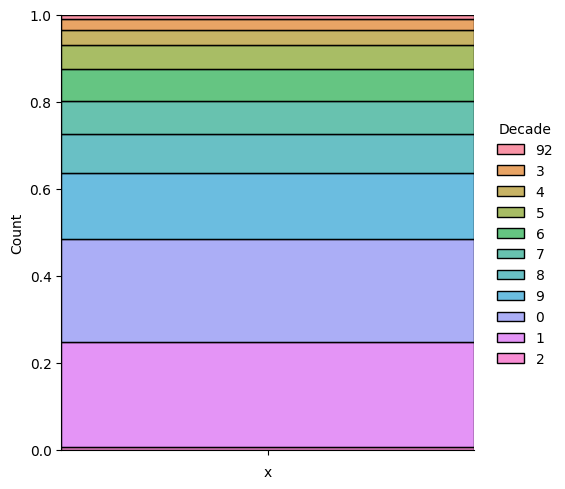

In [32]:
# sns.catplot(data=df_movies, x='Decade', kind='count')
df_movies['x']=''
df_movies.pipe(lambda df: sns.displot(data=df, x='x', hue='Decade',multiple='fill', hue_order = ['92','3','4','5','6','7','8','9','0','1','2']))
df_movies.drop('x', inplace = True, axis = 1)

Se observa que la cantidad de películas por década aumenta a medida que el tiempo avanza. Se consideran 100 años y los últimos 20 contienen aproximadamente el 50% de las películas del dataset.

## Star

<AxesSubplot: xlabel='Actores', ylabel='count'>

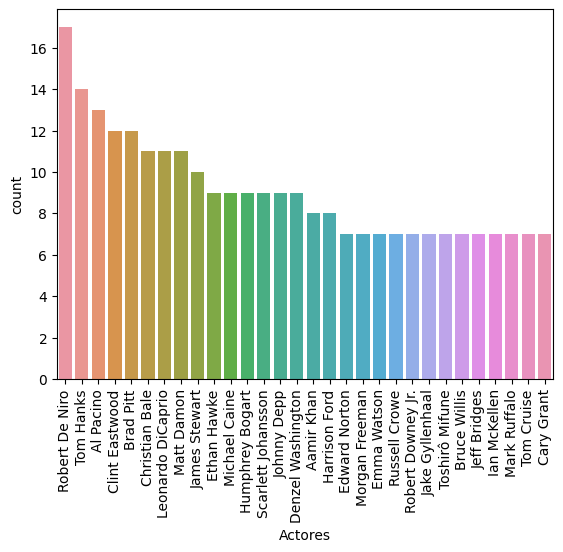

In [33]:
df = pd.DataFrame(actores_totales)
df.columns = ['Actores']
plt.xticks(rotation=90)
sns.countplot(data = df, x='Actores', order=pd.value_counts(pd.Series(actores_totales)).iloc[:30].index)

El top 3 de actores con mayor número de apariciones en las mejores 1000 películas de IMDB lo compone Robert de Niro, seguido de Tom Hanks y Al Pacino. Sería bueno considerar recomendar películas basadas en su cast.

## Genre

<AxesSubplot: xlabel='Actores', ylabel='count'>

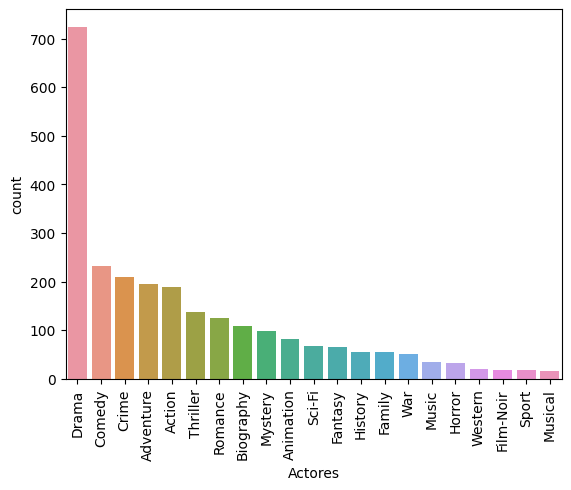

In [34]:
df = pd.DataFrame(generos_totales)
df.columns = ['Actores']
plt.xticks(rotation=90)
sns.countplot(data = df, x='Actores', order=pd.value_counts(pd.Series(generos_totales)).index)

El género predominante, con diferencia es "Drama", seguido de "Comedy", y "Crime". Las películas recomendadas deben tener género similar.

## Certificate

<AxesSubplot: xlabel='Certificate', ylabel='count'>

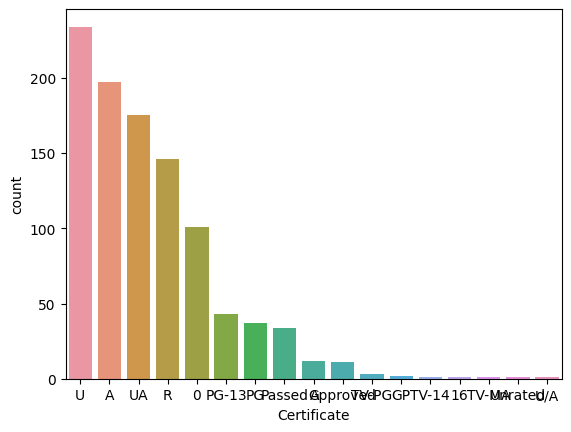

In [35]:
# sns.catplot(data=df_movies, x='Decade', kind='count')
sns.countplot(data = df_movies, x='Certificate', order = df_movies['Certificate'].value_counts().index)

La categoría más abundante de películas corresponde a "U", que es para toda edad. Seguido de A y UA.
Esta variable puede ser un indicador para recomendar películas para el mismo grupo de edades.

## Distribuciones

### IMDB Rating

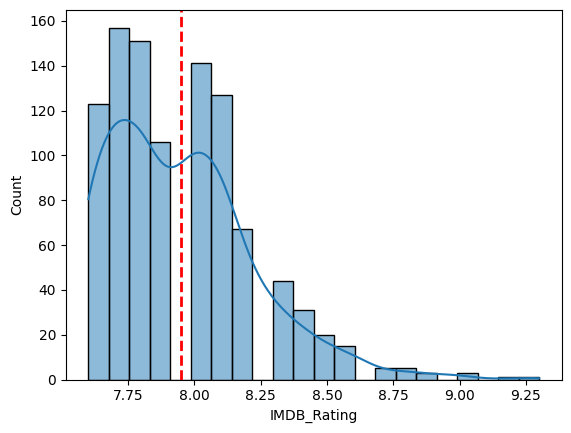

In [36]:
sns.histplot(data=df_movies, x='IMDB_Rating', kde=True)
plt.axvline(x=df_movies['IMDB_Rating'].mean(), color ='red', linestyle='dashed', linewidth=2)

### Meta score

<AxesSubplot: xlabel='Meta_score', ylabel='Count'>

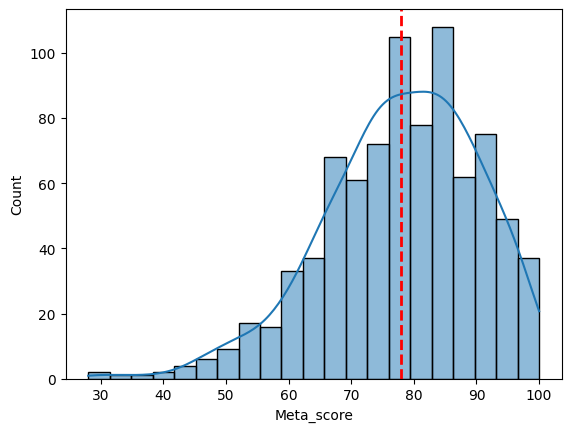

In [37]:
plt.axvline(x=df_movies[df_movies['Meta_score'] > 0]['Meta_score'].mean(), color ='red', linestyle='dashed', linewidth=2)
sns.histplot(data=df_movies[df_movies['Meta_score'] > 0], x='Meta_score', kde=True)

### Gross

<AxesSubplot: xlabel='Gross', ylabel='Count'>

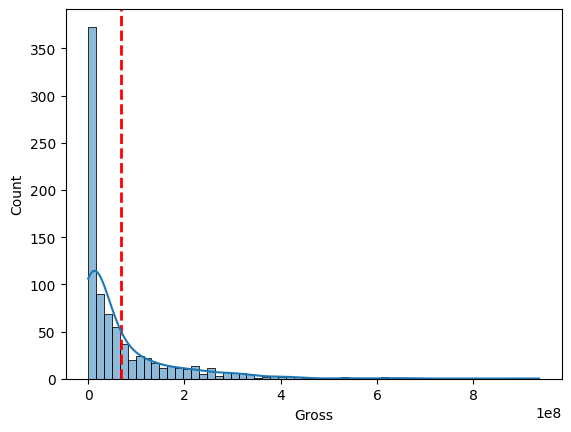

In [38]:
plt.axvline(x=df_movies[df_movies['Gross'] > 0]['Gross'].mean(), color ='red', linestyle='dashed', linewidth=2)
sns.histplot(data=df_movies[df_movies['Gross'] > 0], x='Gross', kde=True)

### Runtime

<AxesSubplot: xlabel='Runtime', ylabel='Count'>

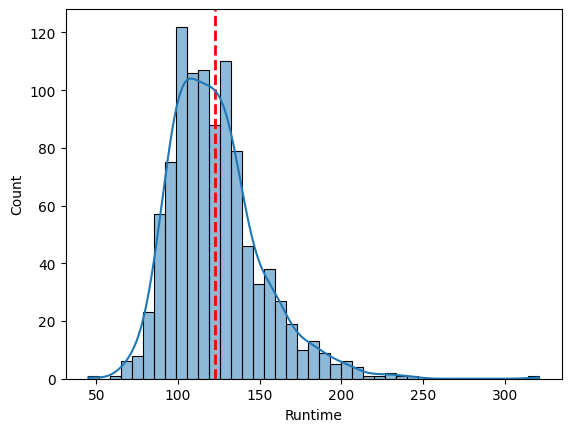

In [39]:
plt.axvline(x=df_movies[df_movies['Runtime'] > 0]['Runtime'].mean(), color ='red', linestyle='dashed', linewidth=2)
sns.histplot(data=df_movies[df_movies['Runtime'] > 0], x='Runtime', kde=True)

### Se usa el título de la película como índice del DataFrame

Usamos como indice el nombre de la pelicula como índice para acceder con mayor facilidad

Primero se tiene que mirar si existen valores duplicados

In [40]:
len(df_movies)-df_movies['Series_Title'].nunique()

1

Hay 1 película duplicada, por lo que se revisa cual es y se agrega el año de release a su nombre para identificarlas.

In [41]:
df_movies[df_movies['Series_Title'].duplicated()]

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,night,collide,town,regime,spree,pig,club,innocent,revolt,terrible
136,https://m.media-amazon.com/images/M/MV5BYmJhZm...,Drishyam,2015,UA,163.0,"Crime, Drama, Mystery",8.2,Desperate measures are taken by a man who trie...,0.0,Nishikant Kamat,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_movies[df_movies['Series_Title'] == 'Drishyam']

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,...,night,collide,town,regime,spree,pig,club,innocent,revolt,terrible
87,https://m.media-amazon.com/images/M/MV5BYmY3Mz...,Drishyam,2013,U,160.0,"Crime, Drama, Thriller",8.3,A man goes to extreme lengths to save his fami...,0.0,Jeethu Joseph,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,https://m.media-amazon.com/images/M/MV5BYmJhZm...,Drishyam,2015,UA,163.0,"Crime, Drama, Mystery",8.2,Desperate measures are taken by a man who trie...,0.0,Nishikant Kamat,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_movies.loc[87,'Series_Title'] = 'Drishyam-2013'
df_movies.loc[136,'Series_Title'] = 'Drishyam-2015'

df_movies_original.loc[87,'Series_Title'] = 'Drishyam-2013'
df_movies_original.loc[136,'Series_Title'] = 'Drishyam-2015'

In [44]:
df_movies.set_index('Series_Title', drop=True, inplace = True)

### Se eliminan columnas innecesarias

Se eliminan las columnas que no se necesitan

In [45]:
df_movies.drop(['Decade', 'IMDB_Rating', 'Runtime', 'Meta_score', 'Gross', 'Poster_Link', 'No_of_Votes', 'Released_Year', 'Certificate', 'Genre', 'Overview', 'Star1', 'Star2','Star3','Star4','Director'], axis = 1, inplace = True)

Se eliminan columnas que solo tienen una coincidencia, pues esta información no es relevante para recomendar otras películas. Por ejemplo, un actor que solo aparece en una película no aporta valor para recomendar otra película basado en el cast.

In [46]:
vertical_sum = df_movies.sum(axis = 0)
columns_to_drop = list(vertical_sum[vertical_sum <= 1].index)

if 'Bucketized_Runtime' in columns_to_drop:
    columns_to_drop.remove('Bucketized_Runtime')

df_movies.drop(columns_to_drop, axis = 1, inplace = True)

In [47]:
df_movies

,Bucketized_Runtime,Genre-War,Genre-Western,Genre-Romance,Genre-Adventure,Genre-Fantasy,Genre-Crime,Genre-History,Genre-Animation,Genre-Drama,...,night,collide,town,regime,spree,pig,club,innocent,revolt,terrible
Series_Title,,,,,,,,,,,,,,,,,,,,,
The Shawshank Redemption,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Godfather,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dark Knight,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Godfather: Part II,1.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Breakfast at Tiffany's,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Giant,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
From Here to Eternity,0.50,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_movies.to_csv('../datasets/processed_movies.csv', index = True)

## Prueba de recomendaciones con similaridad de coseno

Se prueba hacer recomendaciones para alguien que vio "The Avengers"

In [49]:
def cosine_similarity(A):
    cosine = np.dot(A,PELICULA_ESCOGIDA)/(np.linalg.norm(A)*np.linalg.norm(PELICULA_ESCOGIDA))
    return cosine

In [50]:
peliculas = df_movies.index
PELICULA_ESCOGIDA = df_movies.loc['The Avengers']

similar_movies = sorted(peliculas, key=lambda x: cosine_similarity(df_movies.loc[x]), reverse = True)

In [51]:
df_movies_original.set_index('Series_Title', drop = True, inplace = True)

In [52]:
df_movies_original.loc[similar_movies[0:10]]

,Poster_Link,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
Series_Title,,,,,,,,,,,,,,,
The Avengers,https://m.media-amazon.com/images/M/MV5BNDYxNj...,2012,UA,143 min,"Action, Adventure, Sci-Fi",8.0,Earth's mightiest heroes must come together an...,69.0,Joss Whedon,Robert Downey Jr.,Chris Evans,Scarlett Johansson,Jeremy Renner,1260806,"623,279,547"
Captain America: Civil War,https://m.media-amazon.com/images/M/MV5BMjQ0MT...,2016,UA,147 min,"Action, Adventure, Sci-Fi",7.8,Political involvement in the Avengers' affairs...,75.0,Anthony Russo,Joe Russo,Chris Evans,Robert Downey Jr.,Scarlett Johansson,663649,"408,084,349"
The Martian,https://m.media-amazon.com/images/M/MV5BMTc2MT...,2015,UA,144 min,"Adventure, Drama, Sci-Fi",8.0,An astronaut becomes stranded on Mars after hi...,80.0,Ridley Scott,Matt Damon,Jessica Chastain,Kristen Wiig,Kate Mara,760094,"228,433,663"
Avengers: Infinity War,https://m.media-amazon.com/images/M/MV5BMjMxNj...,2018,UA,149 min,"Action, Adventure, Sci-Fi",8.4,The Avengers and their allies must be willing ...,68.0,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,834477,"678,815,482"
Iron Man,https://m.media-amazon.com/images/M/MV5BMTczNT...,2008,UA,126 min,"Action, Adventure, Sci-Fi",7.9,"After being held captive in an Afghan cave, bi...",79.0,Jon Favreau,Robert Downey Jr.,Gwyneth Paltrow,Terrence Howard,Jeff Bridges,939644,"318,412,101"
Avengers: Endgame,https://m.media-amazon.com/images/M/MV5BMTc5MD...,2019,UA,181 min,"Action, Adventure, Drama",8.4,After the devastating events of Avengers: Infi...,78.0,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Evans,Mark Ruffalo,809955,"858,373,000"
Thor: Ragnarok,https://m.media-amazon.com/images/M/MV5BMjMyND...,2017,UA,130 min,"Action, Adventure, Comedy",7.9,"Imprisoned on the planet Sakaar, Thor must rac...",74.0,Taika Waititi,Chris Hemsworth,Tom Hiddleston,Cate Blanchett,Mark Ruffalo,587775,"315,058,289"
Interstellar,https://m.media-amazon.com/images/M/MV5BZjdkOT...,2014,UA,169 min,"Adventure, Drama, Sci-Fi",8.6,A team of explorers travel through a wormhole ...,74.0,Christopher Nolan,Matthew McConaughey,Anne Hathaway,Jessica Chastain,Mackenzie Foy,1512360,"188,020,017"
Guardians of the Galaxy,https://m.media-amazon.com/images/M/MV5BMTAwMj...,2014,UA,121 min,"Action, Adventure, Comedy",8.0,A group of intergalactic criminals must pull t...,76.0,James Gunn,Chris Pratt,Vin Diesel,Bradley Cooper,Zoe Saldana,1043455,"333,176,600"


En las primeras 10 recomendaciones se encuentran otras películas de Marvel así como películas Acción, Aventura y Ciencia ficción. También con la clasificación (Certificate) y duración similar de la película "The Avengers".